In [42]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from ml_logic.data_preprocessing import clean_data, resample_pings
from ml_logic.metric import haversine_mae, position_extrapolation
from ml_logic.data_preprocessing import get_raw_data, download_source_files

In [40]:
# download_source_files(start_date= "2024-11-01",
#                       end_date="2024-11-30",
#                       lon_west=-95.03697,
#                       lon_east= -77.20977,
#                       lat_north=29.46889,
#                       lat_south= 22.50707,
#                       output_path= "../data")

In [43]:
# get initial data frame
df = pd.read_parquet("../data/raw/ais_merged.parquet")


In [44]:
#clean data
df = clean_data(df)
#resample data
df_resampled = resample_pings(df, interval="10min")

/Users/pablorougerie/code/Projets/shanty_project/ml_logic/data_preprocessing.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dimension_cols] = df[dimension_cols].replace(0, np.nan)


In [45]:
#global number
print(f"Total number of pings: {df_resampled.shape[0]}")
print(f"Total number of tracked vessels: {df_resampled["MMSI"].nunique()}")

Total number of pings: 4290874
Total number of tracked vessels: 2437


In [46]:
# distribution of track duration

track_duration = df_resampled["MMSI"].value_counts()
track_duration

MMSI
368270390    4320
303071000    4320
367622660    4320
367624350    4320
367633000    4320
             ... 
354530000       1
563139800       1
334219108       1
636021509       1
323152000       1
Name: count, Length: 2437, dtype: int64

<Axes: >

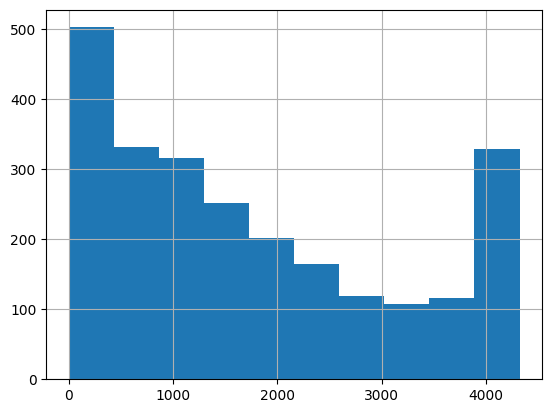

In [47]:
track_duration.hist()

In [48]:

def eligible_tracks(df: pd.DataFrame, lookback_length: int, prediction_horizon: int):
    """
    From a AIS dataframe, generates a pd.Series with the number of eliglble
    track sequences per vessels.
    Input:
    seq_length:
        size of the lookback window for recurring network (in time step)
    prediction_horizon:
        time horizon for position prediction (in time steps)

    Output:
    pdSeries

    """
    #total track duration in time steps, by vessel
    full_track_length = df["MMSI"].value_counts() #a pd.Series
    #nb of eligible time sequences by vessel
    nb_tracks = np.maximum(0,full_track_length - (lookback_length + prediction_horizon))
    #time seq generated by sliding windows, so the diff is the nb of possible seq.
    #set to zero if diff is negative: vessel not tracked long enough to generate a track

    return nb_tracks


In [49]:
seq_pairs = {"1h_2h": (6, 12), #1h horizon, 2h lookback
             "4h_8h": (24,48), #4h horizon, 8h lookback
             "12h_12h": (72,72), #12h horizon, 12h lookback
             "24h_16h": (144,96)} #24h horizon, 16h lookback (middle ground)

In [50]:
eligible_tracks_df = pd.DataFrame(index= track_duration.index, columns=seq_pairs.keys())
for key, val in seq_pairs.items():
    horizon, lookback = val
    tracks = eligible_tracks(df = df_resampled,
                             lookback_length= lookback,
                             prediction_horizon= horizon)
    eligible_tracks_df[key] = tracks

In [51]:
eligible_tracks_df

,1h_2h,4h_8h,12h_12h,24h_16h
MMSI,,,,
368270390,4302,4248,4176,4080
303071000,4302,4248,4176,4080
367622660,4302,4248,4176,4080
367624350,4302,4248,4176,4080
367633000,4302,4248,4176,4080
...,...,...,...,...
354530000,0,0,0,0
563139800,0,0,0,0
334219108,0,0,0,0


In [ ]:
#total number of eligble tracks:
eligible_tracks_df.sum(axis= 0)

1h_2h      4247485
4h_8h      4120299
12h_12h    3958145
24h_16h    3751549
dtype: int64

In [57]:
#total number of boats with eligble tracks:
(eligible_tracks_df > 0).sum()

1h_2h      2399
4h_8h      2310
12h_12h    2204
24h_16h    2095
dtype: int64

array([[<Axes: title={'center': '1h_2h'}>,
        <Axes: title={'center': '4h_8h'}>],
       [<Axes: title={'center': '12h_12h'}>,
        <Axes: title={'center': '24h_16h'}>]], dtype=object)

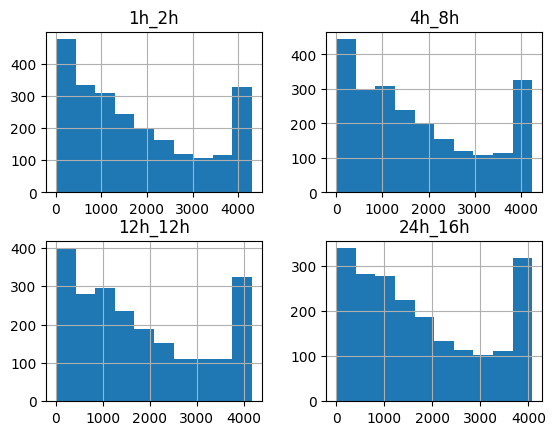

In [ ]:
#distribution of eligible tracks by vessel
eligible_tracks_df[eligible_tracks_df >0].hist()

In [ ]:
#distribution of eligible tracks per vessels
eligible_tracks_df[eligible_tracks_df >0].describe()

,1h_2h,4h_8h,12h_12h,24h_16h
count,2399.000000,2310.000000,2204.000000,2095.000000
mean,1770.523135,1783.679221,1795.891561,1790.715513
std,1381.545253,1364.041730,1339.963361,1312.267456
min,2.000000,1.000000,2.000000,1.000000
25%,557.500000,614.750000,656.000000,676.500000
50%,1437.000000,1454.500000,1469.000000,1459.000000
75%,2845.000000,2853.000000,2883.000000,2914.500000
max,4302.000000,4248.000000,4176.000000,4080.000000


We have an imbalanced distributions of tracks between vessels which can biase the dataset toward behavior os some specific vessels. 
To address that, we'll try to cap the min number of tracks and see how that affect the number of eligible vessels, tracks, and the distribution. 



=== MIN TRACKS AT 5...====
             1h_2h        4h_8h      12h_12h      24h_16h
count  2393.000000  2302.000000  2199.000000  2089.000000
mean   1774.954450  1789.868375  1799.967258  1795.852561
std    1380.434814  1362.355735  1338.753379  1310.639392
min       6.000000     6.000000     6.000000     6.000000
25%     564.000000   624.000000   665.500000   683.000000
50%    1442.000000  1458.000000  1472.000000  1468.000000
75%    2846.000000  2853.750000  2890.000000  2916.000000
max    4302.000000  4248.000000  4176.000000  4080.000000


=== MIN TRACKS AT 10...====
             1h_2h        4h_8h      12h_12h      24h_16h
count  2384.000000  2297.000000  2193.000000  2085.000000
mean   1781.626258  1793.746626  1804.871409  1799.283453
std    1378.751887  1361.296136  1337.291227  1309.550427
min      11.000000    11.000000    12.000000    11.000000
25%     571.500000   626.000000   675.000000   684.000000
50%    1450.000000  1458.000000  1476.000000  1475.000000
75%    2858.2

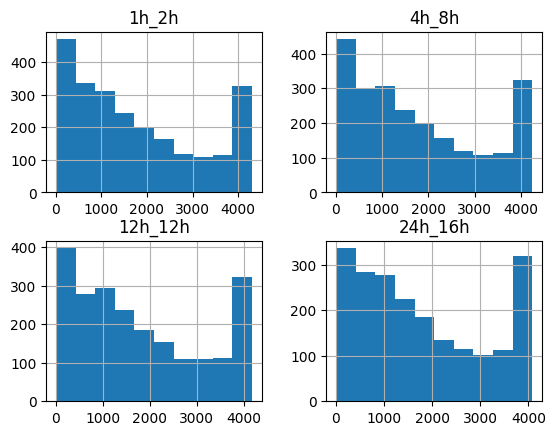

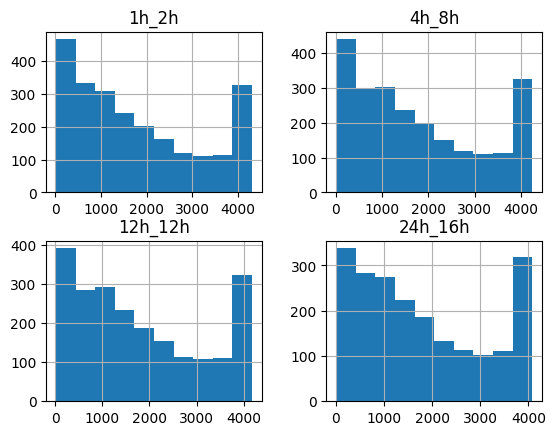

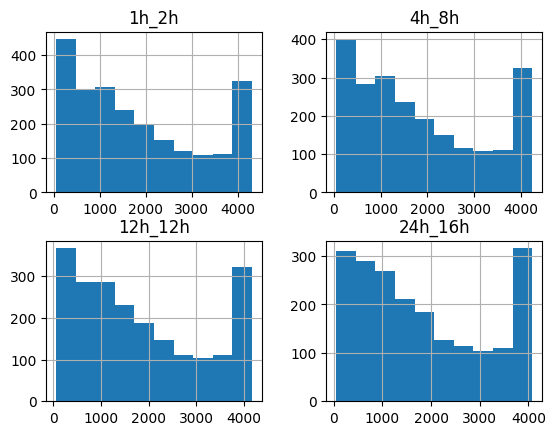

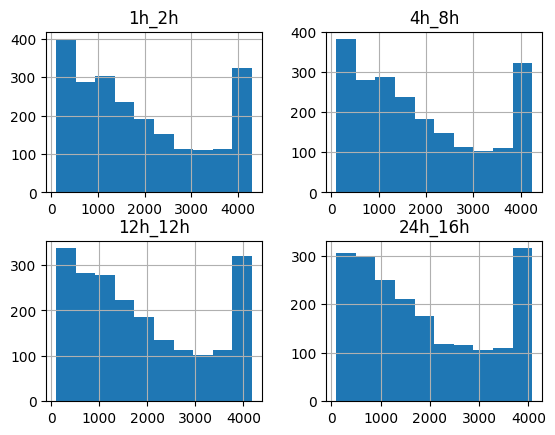

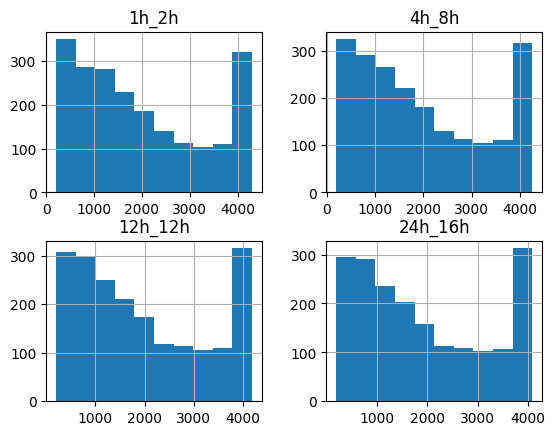

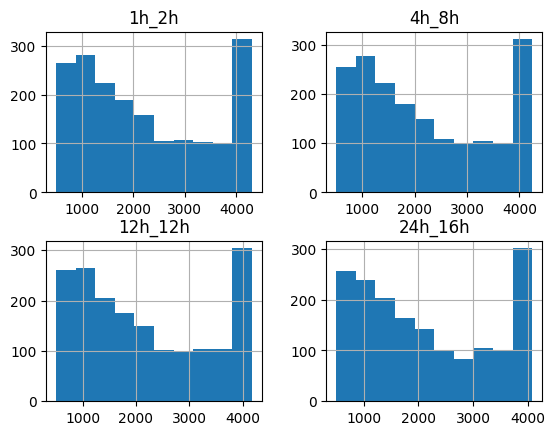

In [ ]:
for min_tracks in [5,10,50,100,200,500]:
    selected_vessels = eligible_tracks_df[eligible_tracks_df > min_tracks]

    print(f"\n")
    print(f"=== MIN TRACKS AT {min_tracks}...====")

    print(selected_vessels.describe())
    selected_vessels.hist()


### Let's select 200 (it's a bit arbitrary but it means that we have already a good min amount of sequence per boat)

In [69]:

print(f"Number of eligible tracks: {(eligible_tracks_df[eligible_tracks_df > 200]).sum()}")
print(f"Number of eligible boats: {eligible_tracks_df[eligible_tracks_df > 200].describe().loc["count"]}")

Number of eligible tracks: 1h_2h      4222592.0
4h_8h      4097369.0
12h_12h    3939092.0
24h_16h    3736277.0
dtype: float64
Number of eligible boats: 1h_2h      2123.0
4h_8h      2061.0
12h_12h    1999.0
24h_16h    1929.0
Name: count, dtype: float64
